In [1]:
%matplotlib widget

import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import LogNorm
import h5py
import scipy
import cupy as cp

import sscCdi
from sscCdi import *
sscCdi.__version__

'0.9.5'

### Nearfield Ptychography  

In [2]:
def RAAR_multiprobe_cupy(diffraction_patterns_list,positions_list,obj,probe,inputs):
    
    iterations = inputs['iterations']
    beta       = inputs['beta']
    epsilon    = inputs['epsilon']
    dx         = inputs['object_pixel']
    wavelength = inputs['wavelength']
    distance   = inputs['detector_distance']
    n_of_modes = inputs["incoherent_modes"]
    fresnel_regime = inputs["fresnel_regime"]
    probe_support  = inputs["probe_support"] 

    if fresnel_regime == True:
        pass
    else:
        inputs['source_distance'] = None

    diffraction_patterns = cp.array(diffraction_patterns) 
    positions = cp.array(positions)
    obj = cp.array(obj)
    probe = cp.array(probe)

    if probe_support is None:
        probe_support = cp.ones_like(probe)
    else:
        probe_support = cp.array(probe_support)

    obj_matrix = cp.ones((n_of_modes,obj.shape[-2],obj.shape[-1]),dtype=complex) 
    obj_matrix[:] = obj # create matrix of repeated object to facilitate slice-wise product with probe modes
    
    shapey,shapex = probe.shape
    wavefronts = cp.ones((len(positions),n_of_modes,probe.shape[0],probe.shape[1]),dtype=complex) # wavefronts contain the wavefront for each probe mode, and for all probe positions
    
    probe_modes = cp.empty((n_of_modes,probe.shape[0],probe.shape[1]),dtype=complex)
    for i in range(0,probe_modes.shape[0]):
        if i == 0:
            probe_modes[i] = probe
        else:
            probe_modes[:] = cp.random.rand(*probe.shape)
    
    for index, (posx, posy, posz) in enumerate(positions):
        obj_box = obj_matrix[:,posy:posy + shapey , posx:posx+ shapex]
        wavefronts[index] = probe_modes*obj_box
        
    error = cp.zeros((iterations,1))
    for iteration in range(0,iterations):
        """
        RAAR update function:
        psi' = [ beta*(Pf*Rr + I) + (1-2*beta)*Pr ]*psi
        psi' = beta*(Pf*Rr + I)*psi + (1-2*beta)*Pr*psi
        psi' = beta*(Pf*Rr*psi + psi) + (1-2*beta)*Pr*psi (eq 1)
        """
        for iz in range(len(multiple_DPs)):
            
            print(f'Plane #{iz}')
            
            # diffraction_patterns = diffraction_patterns_list[iz]
            # positions = positions_list[iz]
            
            for index, (posx, posy, posz) in enumerate(positions):

                inputs['detector_distance'] = z1z2 - posz
                inputs['source_distance'] = posz

                obj_box = obj_matrix[:,posy:posy + shapey , posx:posx+ shapex]

                psi_after_Pr = probe_modes*obj_box

                psi_after_reflection_Rspace = 2*psi_after_Pr-wavefronts[index]
                psi_after_projection_Fspace, _ = update_exit_wave_multiprobe_cupy(psi_after_reflection_Rspace,diffraction_patterns[index],inputs) # Projection in Fourier space
                wavefronts[index] = beta*(wavefronts[index] + psi_after_projection_Fspace) + (1-2*beta)*psi_after_Pr 

            probe_modes, single_obj_box = projection_Rspace_multiprobe_RAAR_cupy(wavefronts,obj_matrix[0],probe_modes,positions[:,0:2],epsilon) # Update Object and Probe! Projection in Real space (consistency condition)
            obj_matrix[:] = single_obj_box # update all obj slices to be the same;

            probe_modes = probe_modes[:]*probe_support

            iteration_error = get_magnitude_error(diffraction_patterns,wavefronts[:,0,:,:],inputs) # should we insert more modes to calculate error?

            print('\r', end='')
            print(f'\tIteration {iteration+1}/{iterations} \tError: {iteration_error:.2e}',end='')

            error[iteration] = iteration_error
        
            # propagate to next plane (obj and probe)
            
    return obj_matrix[0].get(), probe_modes.get(), error.get()



(Text(0.5, 0, 'X [um]'), Text(0.5, 0.5, 'Y [um]'), Text(0.5, 0, 'Z [um]'))

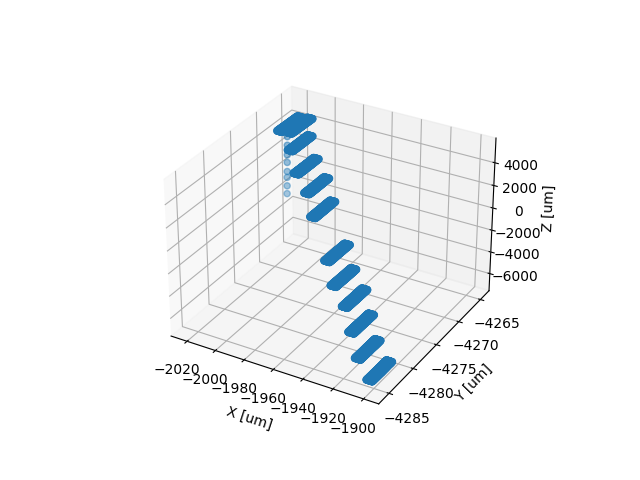

In [3]:
start = 0
empty = np.load('/ibira/lnls/labs/tepui/home/yuri.tonin/00000000/data/mogno/RHD_Salditt/empty.npy')
positions0 = np.load('/ibira/lnls/labs/tepui/home/yuri.tonin/00000000/data/mogno/RHD_Salditt/multiZ/positions.npy')[start:]*1e3

fig = plt.figure()
ax = fig.add_subplot(projection='3d')
ax.scatter(positions0[:,0],positions0[:,1],positions0[:,2],'o')
ax.set_xlabel('X [um]'), ax.set_ylabel('Y [um]'), ax.set_zlabel('Z [um]')

# fig, ax = plt.subplots()
# ax.plot(positions0[:,0],positions0[:,1],'o')
# ax.set_xlabel('X [um]'), ax.set_ylabel('Y [um]')
# ax.grid()

In [4]:
empty.shape, positions0.shape

((2048, 2048), (19680, 3))

In [12]:
folder_path = '/ibira/lnls/labs/tepui/home/yuri.tonin/00000000/data/mogno/RHD_Salditt/multiZ/'
data_shape = (2048,2048)
n_points_per_z = 41*40
n_of_z = 12



In [23]:
A = 3 # wanted number of z positions

DPs_multiple_planes = []
positions_multiple_planes = []
for i in range(0,A):
    data = np.load(folder_path+f"z_{i}.npy")
    print(f"Data #{i} shape = {data.shape}. {data.shape[0]*data.shape[1]}")
    DP = data.reshape(n_points_per_z,data_shape[0],data_shape[1])
    positions1 = positions0[i*n_points_per_z:(i+1)*n_points_per_z]
    print(f"Positions #{i} shape = {positions1.shape}")    
    if i == 0:
        DP = DP[10:] # remove weird first points
        positions1 = positions1[10:]    
    DPs_multiple_planes.append(DP)
    positions_multiple_planes.append(positions1) 
    
for i, j in zip(DPs_multiple_planes, positions_multiple_planes):
    print(i.shape,j.shape)

Data #0 shape = (41, 40, 2048, 2048). 1640
Positions #0 shape = (1640, 3)
Data #1 shape = (41, 40, 2048, 2048). 1640
Positions #1 shape = (1640, 3)
Data #2 shape = (41, 40, 2048, 2048). 1640
Positions #2 shape = (1640, 3)
(1630, 2048, 2048) (1630, 3)
(1640, 2048, 2048) (1640, 3)
(1640, 2048, 2048) (1640, 3)


In [18]:
minimal_diff = 1 # 10e-6

def round_z_values_to_average(positions1,min_step = 1):

    new_positions = np.empty((positions1.shape[0],4))
    
    z = positions1[:,2].copy()
    
    difz = np.diff(z)
    difz = np.append(difz,0) # extend the dimensions to be the same of z
    difz = np.where(np.abs(difz)>min_step,500,0)
    plane_number = np.empty_like(difz)
    number = 0

    for i in range(0,plane_number.shape[0]): # populate array that number the plane
        plane_number[i] = int(number)
        if difz[i] > 0: number += 1

    for i in range(0,plane_number.max()+1):
        same_plane_values = z[plane_number == i]
        mean = np.mean(same_plane_values)
        z[plane_number == i] = mean

#     fig, ax = plt.subplots()
#     ax.plot(positions1[:,2], 'o-')
#     ax.plot(difz, 'o-')
#     ax.plot(plane_number, 'o-')
#     ax.plot(z, 'o-')
    
    new_positions[:,0] = positions1[:,0]
    new_positions[:,1] = positions1[:,1]
    new_positions[:,2] = z
    
    return new_positions[:,0:3]

def get_equivalent_geometry(positions_original,z1,z2):

    # see geometry of Fig 3 in https://doi.org/10.1364/OE.487002
    # z1 = np.max(z) is the distance from focus to the last sample plane
    # z2 is the distance from last sample plane to detector
    
    def M_dz(z1,z2,dz):
        return (z1+z2)/(z1-dz)
    
    x,y,z, numbering = positions[:,0], positions[:,1], positions[:,2]
    T = z1 - np.min(z)
    M_T = M_dz(z1,z2,T)
    
    dz = z1 - z # distance between down-beam plane to the current plane 
    magnifications = (z1+z2)/(z1-dz) # magnification as a function of z position
    
    equivalent_geometry_positions = np.empty_like(positions)
    equivalent_geometry_positions[:,0] = x*magnifications # rescaling x values according to respective magnification
    equivalent_geometry_positions[:,1] = y*magnifications # rescaling y   
    equivalent_geometry_positions[:,2] = (z2-z)*magnifications # non-linear scaling of z

    return equivalent_geometry_positions

In [16]:
# %matplotlib widget
# sscCdi.misc.deploy_visualizer(DPs,type='abs',title='CC',cmap='gray',axis=0) # select axis

In [17]:
positions1.shape,empty.shape, DP.shape, n_points_per_z, n_of_z

((4910, 3), (2048, 2048), (4910, 2048, 2048), 1640, 12)

zmin = 1.742mm
Object pixel = 1.44e-06 m
Probe shape = (2048, 2048)
Deleting 6350 slices
Size of the array: 6.25 GB
Object shape = (20450, 7061)
FOV = [29448.   10167.84] um2
Data shape = (200, 2048, 2048)
Positions shape = (200, 3)


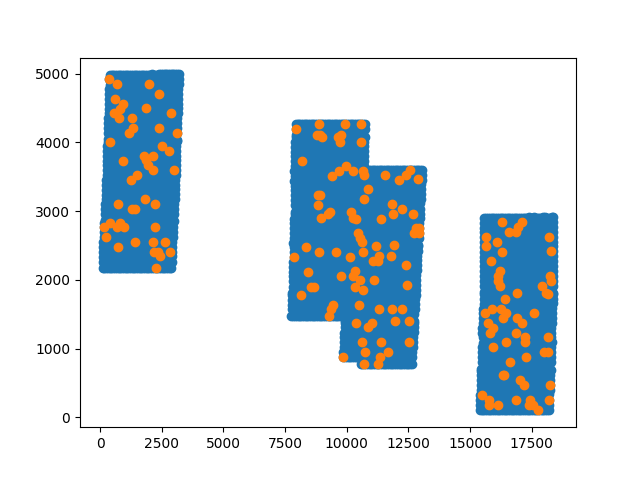

In [46]:
positions = positions1.copy()*1e-6

z1 = np.max(positions[:,2])
z2 = 1 - z1
M0 = (z2+z1)/z1
print(f'z1={z1}, z2={z2}, M={M}')

c_speed = 299792458        # Velocity of Light [m/s]
planck  = 4.135667662E-18  # Plank constant [keV*s]
n_pixels = 2048

inputs = {
"n_cpus": 32, # cpu cores
"energy": 22, #keV
"detector_distance": z2, # meter
"detector_pixel_size": 1.44e-6, # PCO pixel size with lens 
"source_distance": 0, # should be 0 if parallel beam
}

new_positions = get_equivalent_geometry(positions,z1,z2)    
inputs["detector_distance"] = inputs["detector_distance"]/M0

wavelength = c_speed * planck / inputs["energy"]
inputs["wavelength"] = wavelength

waist = 250e-9/2
zmin = 2*np.pi*waist**2/wavelength
print(f'Minimal required distance from focus = {zmin*1e3:.3f}mm')

inputs['object_pixel'] = inputs["detector_pixel_size"]
print(f'Object pixel = {inputs["object_pixel"]} m')

positions *= 1e-3
# positions = np.roll(positions,shift=1,axis=1)

probe = np.ones_like(empty)
print(f'Probe shape = {probe.shape}')

inputs["object_padding"] = 100
positions[:,0:2] = sscCdi.convert_probe_mogno_positions_meters_to_pixels(positions[:,0:2].copy(),inputs["object_pixel"],inputs["object_padding"])

N = 40
fig, ax = plt.subplots()
ax.plot(positions[:,0],positions[:,1],'o')

if 1: # remove random points from data
    n_of_points_to_keep = 200
    start_idx = positions.shape[0] - n_of_points_to_keep
    slices_to_ignore = np.random.permutation(positions.shape[0])[-start_idx::]
    print(f'Deleting {slices_to_ignore.shape[0]} slices')
    DPs = np.delete(DP,slices_to_ignore,axis=0)
    positions = np.delete(positions,slices_to_ignore,axis=0)

ax.plot(positions[:,0],positions[:,1],'o')

size_in_bytes = DPs.nbytes # Get the size of the array in bytes
size_in_gb = size_in_bytes / (1024**3) # Convert the size to gigabytes
print("Size of the array:", size_in_gb, "GB")

inputs = sscCdi.set_object_shape(inputs, DPs.shape, positions[:,0:2])
# inputs["object_shape"] = (inputs["object_shape"][1],inputs["object_shape"][0])
print(f'Object shape = {inputs["object_shape"]}')
print(f'FOV = {np.asarray(inputs["object_shape"])*inputs["object_pixel"]*1e6} um2')
print(f'Data shape = {DPs.shape}')
print(f'Positions shape = {positions.shape}')

model_object = np.ones(inputs["object_shape"])

probe_guess = np.ones_like(probe) + 1j
probe_guess = probe + 1j
# probe_guess = DPs.mean(0)
obj_guess = np.ones_like(model_object) # constant object

inputs['iterations'] = 10   
inputs["fresnel_regime"] = True
inputs["probe_support"] = None
inputs["incoherent_modes"] = 1
inputs['beta'] = 0.9 # RAAR
inputs['epsilon'] = 0.001 # RAAR; small value to add to probe/object update denominator

# print(positions.shape, DPs.shape, probe_guess.shape, obj_guess.shape, inputs)
RAAR_obj, RAAR_probes, _ = RAAR_multiprobe_cupy(DPs,positions,obj_guess,probe_guess,inputs)


5.6356453357367875e-11 1.44e-06 0.996721935 0.0032780649999999997


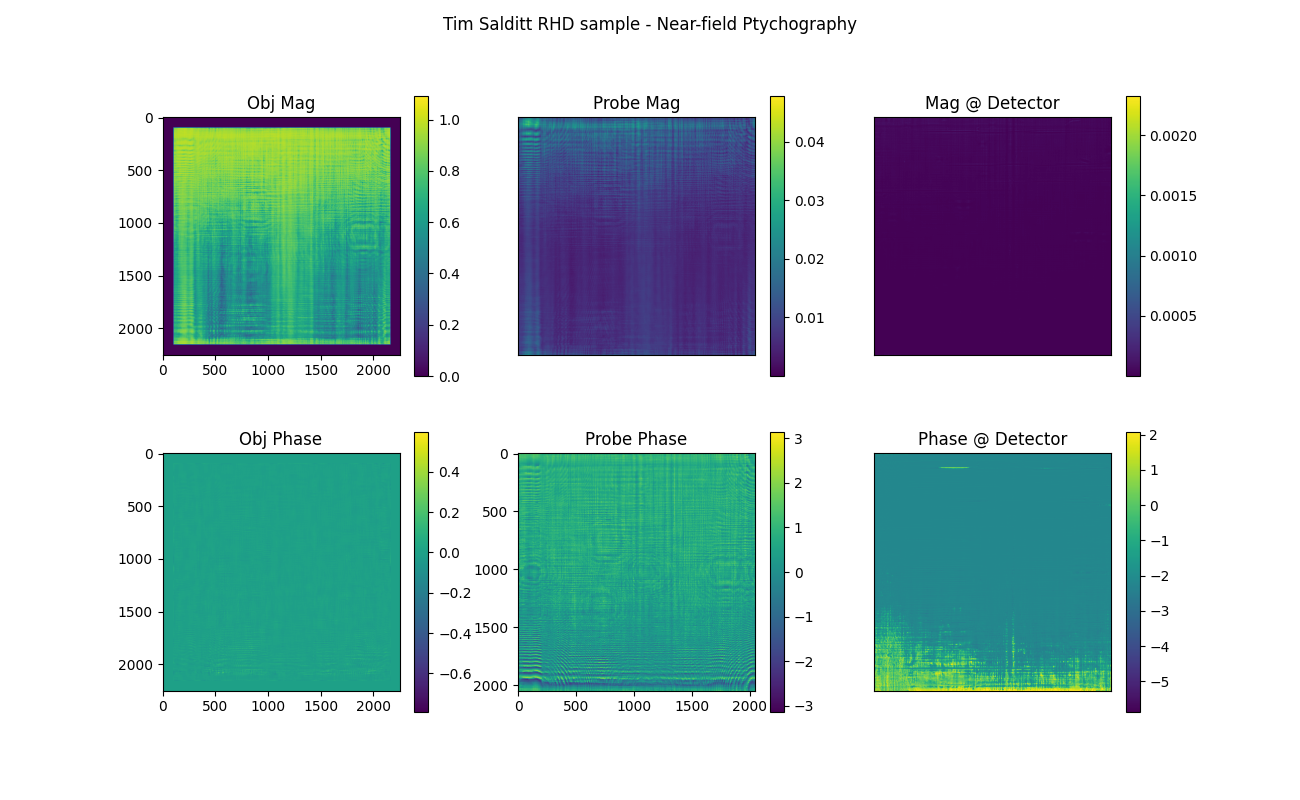

((2250, 2250), (1, 2048, 2048))

In [9]:
print(inputs["wavelength"],inputs["detector_pixel_size"],inputs["detector_distance"],float(inputs["source_distance"]))
propagated_probe = sscCdi.fresnel_propagator_cone_beam(RAAR_probes[0],inputs["wavelength"],inputs["detector_pixel_size"],inputs["detector_distance"].get(), inputs["source_distance"].get())


if 1: # plot
    fig, ax = plt.subplots(2,3,figsize=(13,8),dpi=100)
    im1=ax[0,0].imshow(np.abs(RAAR_obj))
    ax[0,0].set_title('Obj Mag')
    # ax[0,0].plot(positions[:,0],positions[:,1],'.',color='gray')
    fig.colorbar(im1, ax=ax[0, 0])

    im2 = ax[1,0].imshow(np.angle(RAAR_obj))
    ax[1,0].set_title('Obj Phase')
    fig.colorbar(im2, ax=ax[1, 0])

    im3 = ax[0,1].imshow(np.abs(RAAR_probes[0]))
    ax[0,1].set_title('Probe Mag')
    fig.colorbar(im3, ax=ax[0, 1])

    im4 = ax[1,1].imshow(np.angle(RAAR_probes[0]))
    ax[1,1].set_title('Probe Phase')
    fig.colorbar(im4, ax=ax[1, 1])

    im5=ax[0,2].imshow(np.abs(propagated_probe))
    ax[0,2].set_title('Mag @ Detector')
    fig.colorbar(im5, ax=ax[0, 2])

    mean = np.mean(np.angle(propagated_probe))
    std=np.std(np.angle(propagated_probe))
    im6 = ax[1,2].imshow(np.angle(propagated_probe),vmin=mean-4*std,vmax=mean+4*std)
    ax[1,2].set_title('Phase @ Detector')
    fig.colorbar(im6, ax=ax[1,2])

    fig.suptitle('Tim Salditt RHD sample - Near-field Ptychography')

    for i, ax in enumerate(ax.ravel()):
        if i==3 or i==0 or i ==4: continue
        ax.set_xticks([])
        ax.set_yticks([])

    plt.show()

RAAR_obj.shape, RAAR_probes.shape